# Importing required packages 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline

In [7]:
from sklearn.metrics import silhouette_score

In [8]:
def pca_results(good_data, pca):
# adapted from: https://github.com/viktortnk/udacity-ml/blob/master/projects/creating_customer_segments/renders.py
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (16,10))

	# Plot the feature weights as a function of the components
	colors = ['r','g','b','y','m','k','c']*2
	components.plot(ax = ax, kind = 'bar', color=colors)
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [9]:
city_columns = {'boston':['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 
                          'Surface_Tp', 'F_F_Class', 'visionzero', 
                          'Conflict', 'intersection', 'jam_percent'],
               'cambridge':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal', 'seeclickfix', 'width',
                           'jam', 'jam_percent'],
                'dc':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal']}



# Loading dataframe used in modeling 

In [10]:
city = 'boston'

In [94]:
df = pd.read_csv('../data/{}/processed/seg_with_predicted.csv'.format(city),
                dtype={'segment_id':'str'})

### Selecting a subset of columns which we will use in further analysis

In [12]:
df_minimal_columns = df[city_columns[city]].fillna(0)

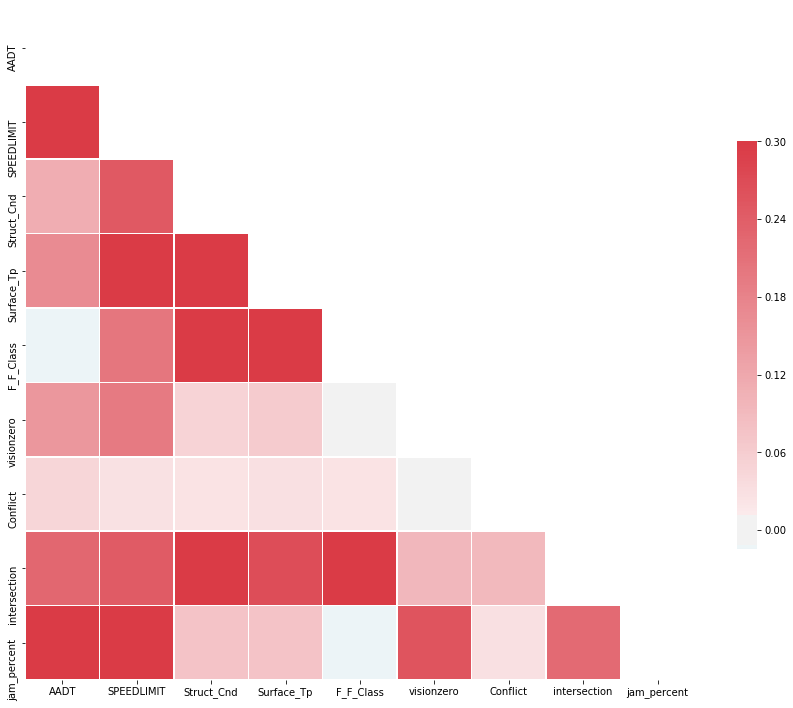

In [13]:
corr = df_minimal_columns.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Apply PCA

In [14]:
from sklearn.metrics.pairwise import cosine_distances

In [15]:
class Clusterer(object):
    
    def __init__(self, X):
        self.X = X
        
    def reduce_dimension(self, method, scale=True):
        if scale:
            X = StandardScaler().fit_transform(self.X)
        else:
            X = self.X
        self.reduce_X = method.fit_transform(X)
    
    def get_dists(self, features=None):
        if features is None:
            features = self.reduce_X
        self.dists = cosine_distances(features)
        
    def cluster(self, method, features=None):
        if features is None:
            features = self.reduce_X
        self.clusterer = method
        self.clusters = self.clusterer.fit_predict(features)
        

In [17]:
#df_cl.cluster(KMeans(init='k-means++', n_clusters=2, n_init=10))

In [18]:
test_dummies = pd.DataFrame()
for c in df_minimal_columns:
    d = pd.get_dummies(df_minimal_columns[c])
    d.columns = [c+'_'+str(col) for col in d.columns]
    test_dummies = pd.concat([test_dummies, d], axis=1)

In [19]:
df_input = df_minimal_columns.fillna(0)
#df_input = test_dummies.fillna(0)
pca = PCA(n_components=4)#,random_state=12345)
# make pipeline
pipe = make_pipeline(StandardScaler(), pca)
pipe.fit(df_input)
pca_result = pipe.fit_transform(df_input)


,Explained Variance,AADT,SPEEDLIMIT,Struct_Cnd,Surface_Tp,F_F_Class,visionzero,Conflict,intersection,jam_percent
Dimension 1,0.3219,0.2574,0.3587,0.4671,0.4786,0.4321,0.1276,0.0497,0.3340,0.2020
Dimension 2,0.1946,0.4745,0.3897,-0.2833,-0.2619,-0.3814,0.3246,0.0381,0.0692,0.4659
Dimension 3,0.1129,0.0241,-0.0627,-0.0471,-0.0722,-0.0347,-0.2125,0.9439,0.2229,-0.0320
Dimension 4,0.1021,-0.4435,-0.3067,0.0498,-0.0065,0.0560,0.7935,0.1593,0.0897,0.2016


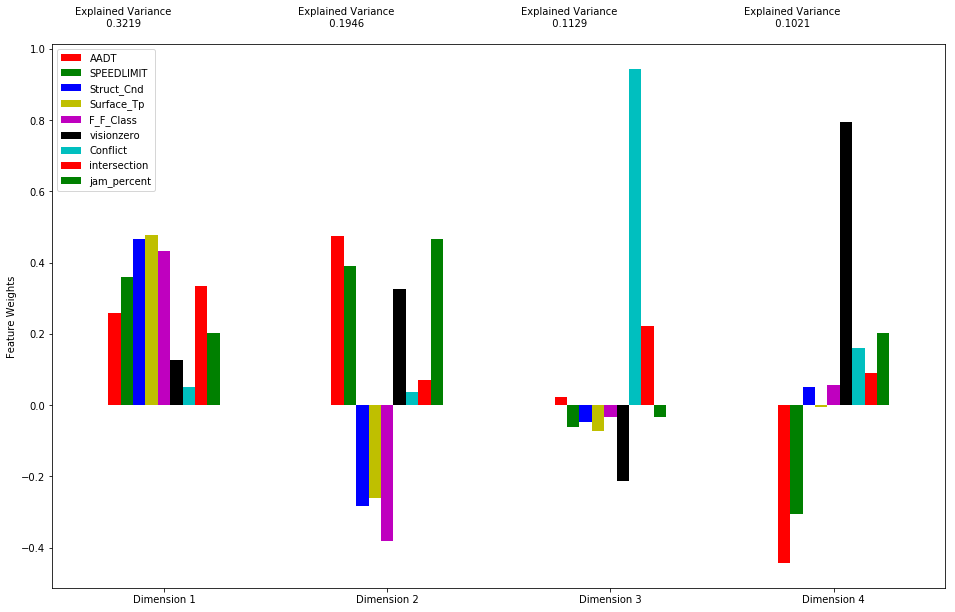

In [20]:
pca_results(df_input, pipe.named_steps.pca)

### High risk (red) and Non high risk segments plotted
High risk = Prediction above a threshold.  Here I use 75 to more clearly indicate highest risk

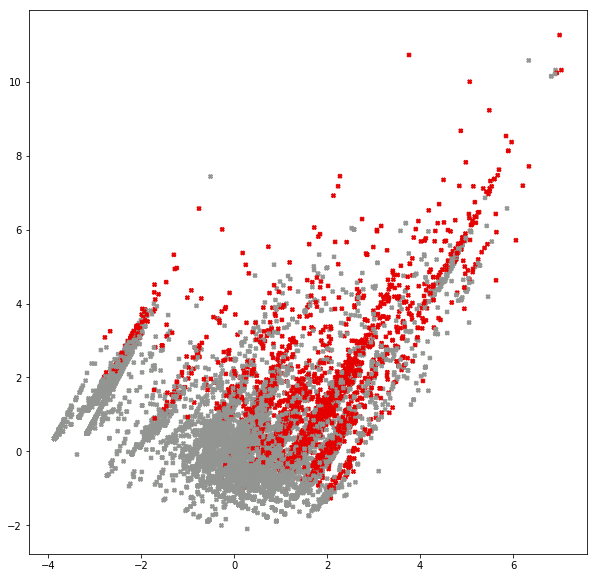

In [21]:
plt.figure(figsize=[10,10])
color_mapping = {False: sns.xkcd_rgb['grey'], True: sns.xkcd_rgb['red']}
colors = list(map(lambda x: color_mapping[x], df.prediction>.75))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X", c = colors)

# Applying KMeans Clustering and trying to list out characteristics of each cluster

In [22]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
        if k>1:
            print(silhouette_score(X, kmeans.labels_))

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

In [ ]:
evaluate_clusters(pca_result,5)
plt.show()

In [34]:
X_scale = preprocessing.normalize(df_minimal_columns, norm='l2')
evaluate_clusters(X_scale,5)
plt.show()

KeyboardInterrupt: 

In [ ]:
#evaluate_clusters(df_minimal_columns.fillna(0),5)
#plt.show()

In [57]:
from sklearn.cluster import KMeans

#INTEGER FOR RANDOM SEEDING 
random_state = 170

n_clusters = 3

y_pred = KMeans(n_clusters=n_clusters, init='k-means++',random_state=random_state).fit_predict(df_minimal_columns)
cluster_labels = y_pred

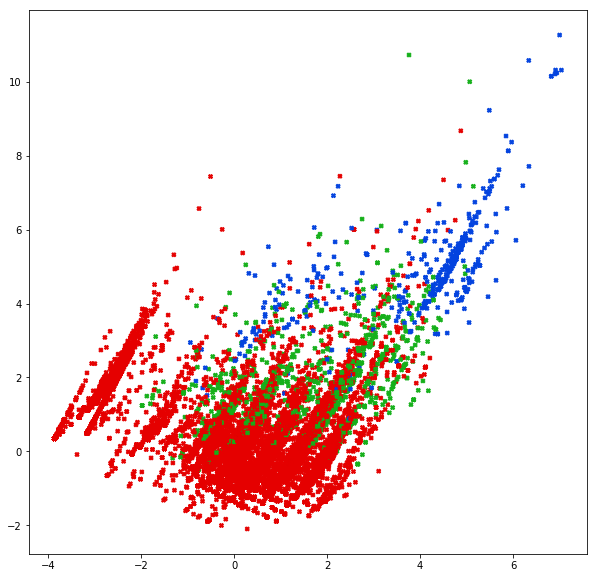

In [58]:
plt.figure(figsize=[10,10])
#vis_x_filtered = vis_x[]
color_mapping = {0: sns.xkcd_rgb['green'], 1: sns.xkcd_rgb['red'], 2: sns.xkcd_rgb['blue'], 
                 3: sns.xkcd_rgb['yellow'], 4: sns.xkcd_rgb['grey']}
colors = list(map(lambda x: color_mapping[x], cluster_labels))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X",
        c = colors
        )

In [59]:
df_minimal_columns['cluster_label'] =  cluster_labels

## Find key characteristics of these clusters
- top features which are different in the given cluster when compared with the rest of the clusters
- select those specific features to explain the characteristics of the clusters

In [55]:
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.model_selection import train_test_split


def get_top_features_from_dataset(data, cluster_labels,n_clusters=3):

    temp_labels = []
    dataset = data.as_matrix()
    labels = set(cluster_labels)
    for label in labels:
        revised_labels = pd.Series(cluster_labels)        
        revised_labels = revised_labels.apply(lambda x: 1 if x == label else 0)
        
        X_train, X_test, y_train, y_test = train_test_split(dataset, revised_labels.as_matrix(),random_state=0,test_size=1)
        fscore = f_classif(X_train,y_train)

        top_feature_set = {
            "cluster_label": str(label),
            "names" : list(data.columns.values),
            "scores" : fscore[0].tolist(),
            "pvalues" : fscore[1].tolist()               
        }    
    
        temp_labels.append(top_feature_set)

    return temp_labels

In [125]:
# make descriptives df
desc_df = df_minimal_columns.copy(deep=True)
desc_df['crash_pct'] = df['target']
desc_df['prediction'] = df['prediction']
profile_desc_df = desc_df.groupby('cluster_label').mean()
# normalize by average
profile_desc_df = profile_desc_df.T.apply(lambda c: c/desc_df.mean()).T
profile_desc_df.drop(['cluster_label'], axis=1, inplace=True)

In [91]:
#df.AADT.groupby(df_minimal_columns.cluster_label).apply(lambda g: g.plot(kind='kde'))

In [104]:
# plot bars for different clusters
def plot_levels(data, levels, by=df_minimal_columns['cluster_label']):
    lv_data = data[levels]
    p = lv_data.groupby(by).mean().T.plot(kind='bar')
    return(p)

Text(0,0.5,'proportion of segments')

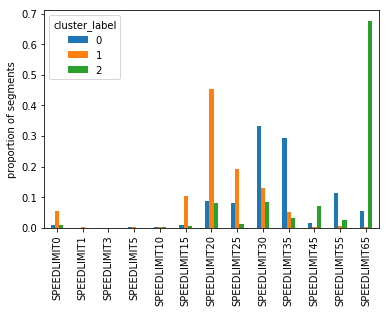

In [105]:
p = plot_levels(df, df.filter(regex='SPEEDLIMIT').iloc[:,1:].columns)
p.set_ylabel('proportion of segments')

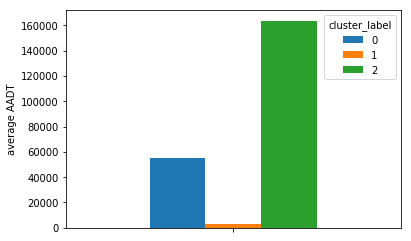

In [111]:
p = plot_levels(df, ['AADT'])
p.set_ylabel('average AADT')
p.set_xticklabels([]);

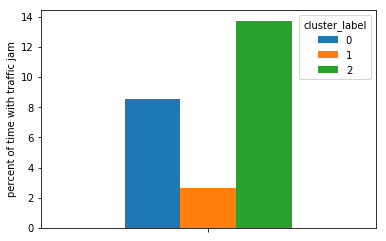

In [114]:
p = plot_levels(df, ['jam_percent'])
p.set_ylabel('percent of time with traffic jam')
p.set_xticklabels([]);

In [52]:
# get the factors of the different columns
col_w_factors = []
for x in df_minimal_columns.columns:
    sub_cols = df.filter(regex=x).columns.tolist()
    if len(sub_cols)>2:
        sub_cols = sub_cols[1:]
    else:
        sub_cols = [sub_cols[0]]
    col_w_factors.extend(sub_cols)

In [60]:
data = df[col_w_factors]
for result in get_top_features_from_dataset(data, cluster_labels,n_clusters):
    #Get top values of pvalues
    top_5_p_values_indices = np.argsort(result['pvalues'])[0:10]
    cluster_df = data[df_minimal_columns['cluster_label'] == int(result['cluster_label'])]
    
    print("\n\nCluster : %s"%str(result['cluster_label']))
    print("-------")
    print("Mean crashes: %1.5f" % df.target.loc[cluster_df.index].mean())
    print("Characteristics of cluster %s"%str(result['cluster_label']))
    
    tmp_df = pd.DataFrame(columns=['feature_name','mean in cluster','mean (overall)','proportion ratio'])
    
    for index in range(len(data.columns)):
        name = result['names'][index]
        tmp_df= tmp_df.append({
            'feature_name': name  ,
            'mean in cluster': cluster_df[name].mean() ,
            'mean (overall)': data[name].mean(),
            'proportion ratio': cluster_df[name].mean() / data[name].mean()
        },ignore_index=True)

        
    print(tmp_df.to_string(index=False))
    

/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.




Cluster : 0
-------
Mean crashes: 0.34459
Characteristics of cluster 0
feature_name  mean in cluster  mean (overall)  proportion ratio
        AADT     55254.180735     8448.523136          6.540099
 SPEEDLIMIT0         0.009930        0.051151          0.194140
 SPEEDLIMIT1         0.000000        0.001242          0.000000
 SPEEDLIMIT3         0.000000        0.000399          0.000000
 SPEEDLIMIT5         0.001986        0.001641          1.209963
SPEEDLIMIT10         0.002979        0.001641          1.814944
SPEEDLIMIT15         0.009930        0.097910          0.101424
SPEEDLIMIT20         0.086395        0.429307          0.201244
SPEEDLIMIT25         0.081430        0.184553          0.441229
SPEEDLIMIT30         0.332671        0.136950          2.429136
SPEEDLIMIT35         0.291956        0.061532          4.744764
SPEEDLIMIT45         0.014896        0.003372          4.417956
SPEEDLIMIT55         0.114201        0.012023          9.498877
SPEEDLIMIT65         0.053625  

In [37]:
from scipy.stats import ttest_ind

In [28]:
cl_g = df.groupby(df_minimal_columns.cluster_label)['target']
cl_target = []
for g in cl_g.groups:
    cl_target.append(cl_g.get_group(g).values)

In [40]:
ttest_ind(cl_target[0], cl_target[2])

Ttest_indResult(statistic=-1.3784464176525197, pvalue=0.16827976243564574)

In [35]:
chi2_contingency(cl_target)

ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

##### 